Face and top-heavy preferential looking

In [1]:
curr_dir = '/home/vayzenbe/GitHub_Repos/GiNN'

import sys
sys.path.insert(1, f'{curr_dir}/Models')
import os, argparse
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image, ImageOps,  ImageFilter

import pandas as pd
import numpy as np
import cornet
import model_funcs


import matplotlib.pyplot as plt
from torchvision import datasets

%matplotlib inline


In [7]:
stim_dir = f"{curr_dir}/Stim/"
weights_dir = f"/lab_data/behrmannlab/vlad/ginn/model_weights"

im_cond = ['vggface']

train_cond = ["mixed_imagenet_vggface","imagenet_oneface", 'general', 'face']
train_cond = ['imagenet_objects']
epochs = [17, 30]

model_type = 'ae'

#model_name = 'cornet_classify'
layer='out'

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])])


In [8]:
def image_loader(image_name):
    #make image grayscale
    image_name = ImageOps.grayscale(image_name).convert("RGB")
    #image_name = image_name.filter(ImageFilter.GaussianBlur(radius=4))
    """load image, returns cuda tensor"""
    image_name = Variable(normalize(to_tensor(scaler(image_name))).unsqueeze(0))
    image_name.cuda()
    return image_name


In [9]:
def save_recon(data, output,model_type, train_cond,epoch):
    inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],std=[1/0.229, 1/0.224, 1/0.225])

    #fig,ax = plt.subplots(1)
    #ax.set_aspect('equal')

    # obtain one batch of training images
    #dataiter = iter(valloader)
    #images, labels = dataiter.next()
    data = data.detach().cpu()
    output = output.detach().cpu()
    data= data.squeeze(0)
    out = output.squeeze(0)

    fig = plt.figure(figsize=(25, 4))
    # display 20 images
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        im = inv_normalize(data[idx])
        ax.imshow(im.permute(1, 2, 0))

    for idx in range(10,20):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        im = inv_normalize(out[idx-10])
        ax.imshow(im.permute(1, 2, 0))

    plt.savefig(f'{curr_dir}/Results/recons/{model_type}_{train_cond}_{epoch}_reconstruction.png', bbox_inches='tight', pad_inches = 0, dpi=200)

In [10]:
def load_files(dirName):
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(dirName):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
            
    return listOfFiles    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


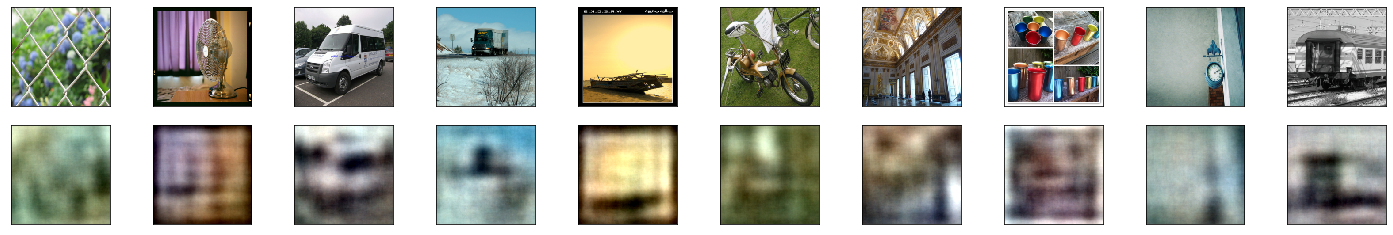

In [21]:

for nc,tc in enumerate(train_cond):
    image_dir = f"/lab_data/behrmannlab/image_sets/{tc}/"
    
    val_dir = image_dir + 'validation'
    #val_dataset = load_stim(val_dir, transform=transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=transform)
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers = 4, pin_memory=True,drop_last= True)

    model = model_funcs.load_model(model_type, tc, epochs[nc], weights_dir,0)
    
    model.eval()
    for data, target in valloader:
        data = data.cuda()
        output = model(data)
        
        break
    
    save_recon(data, output,model_type, tc,epochs[nc])
